# **Final Project Task 3 - Census Modeling Regression**

Requirements
- Create a regression model on the Census dataset, with 'hours-per-week' target

- You can use models (estmators) from sklearn, but feel free to use any library for traditional ML. 
    - Note: in sklearn, the LinearRegression estimator is based on OLS, a statistical method. Please use the SGDRegressor estimator, since this is based on gradient descent. 
    - You can use LinearRegression estimator, but only as comparison with the SGDRegressor - Optional.

- Model Selection and Setup **2p**:
    - Implement multiple models, to solve a regression problem using traditional ML: 
        - Linear Regression
        - Decision Tree Regression
        - Random Forest Regression - Optional
        - Ridge Regression - Optional
        - Lasso Regression - Optional
    - Choose a loss (or experiment with different losses) for the model and justify the choice. *1p*
        - MSE, MAE, RMSE, Huber Loss or others
    - Justify model choices based on dataset characteristics and task requirements; specify model pros and cons. *1p*


- Data Preparation
    - Use the preprocessed datasets from Task 1.
    - From the train set, create an extra validation set, if necesarry. So in total there will be: train, validation and test datasets.
    - Be sure all models have their data preprocessed as needed. Some models require different, or no encoding for some features.


- Model Training and Experimentation **10p**
    - Establish a Baseline Model *2p*
        - For each model type, train a simple model with default settings as a baseline.
        - Evaluate its performance to establish a benchmark for comparison.
    - Make plots with train, validation loss and metric on epochs (or on steps), if applicable. - Optional
    - Feature Selection: - Optional
        - Use insights from EDA in Task 2 to identify candidate features by analyzing patterns, relationships, and distributions.
    - Experimentation: *8p*
        - For each baseline model type, iteratively experiment with different combinations of features and transformations.
        - Experiment with feature engineering techniques such as interaction terms, polynomial features, or scaling transformations.
        - Identify the best model which have the best performance metrics on test set.
        - You may need multiple preprocessed datasets preprocessed
- Hyperparameter Tuning - Optional
  - Perform hyperparameter tuning only on the best-performing model after evaluating all model types and experiments. 
  - Consider using techniques like Grid Search for exhaustive tuning, Random Search for quicker exploration, or Bayesian Optimization for an intelligent, efficient search of hyperparameters.
  - Avoid tuning models that do not show strong baseline performance or are unlikely to outperform others based on experimentation.
  - Ensure that hyperparameter tuning is done after completing feature selection, baseline modeling, and experimentation, ensuring that the model is stable and representative of the dataset.


- Model Evaluation **3p**
    - Evaluate models on the test dataset using regression metrics: *1p*
        - Mean Absolute Error (MAE)
        - Mean Squared Error (MSE)
        - Root Mean Squared Error (RMSE)
        - R² Score
    - Choose one metric for model comparison and explain your choice *1p*
    - Compare the results across different models. Save all experiment results  into a table. *1p*

Feature Importance - Optional
- For applicable models (e.g., Decision Tree Regression), analyze feature importance and discuss its relevance to the problem.



Deliverables

- Notebook code with no errors.
- Code and results from experiments. Create a table with all experiments results, include experiment name, metrics results.
- Explain findings, choices, results.
- Potential areas for improvement or further exploration.


**0. Instalare de librarii si incarcare de date:**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import SGDRegressor, LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV

In [2]:
data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
columns = [
    "age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
    "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss",
    "hours-per-week", "native-country", "income"
]
df = pd.read_csv(data_url, header=None, names=columns, na_values=" ?", skipinitialspace=True)
df.sample(10)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
20509,37,Private,405644,1st-4th,2,Married-spouse-absent,Farming-fishing,Other-relative,White,Male,0,0,77,Mexico,<=50K
19344,25,Self-emp-not-inc,72338,HS-grad,9,Never-married,Sales,Unmarried,Asian-Pac-Islander,Female,0,0,40,United-States,<=50K
16771,33,Private,215306,Assoc-voc,11,Never-married,Other-service,Not-in-family,White,Male,0,0,40,Cuba,<=50K
25772,63,?,106648,HS-grad,9,Married-civ-spouse,?,Husband,White,Male,0,0,25,United-States,<=50K
12000,37,Self-emp-not-inc,75050,Assoc-voc,11,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,55,United-States,<=50K
23629,43,Local-gov,301638,12th,8,Married-civ-spouse,Transport-moving,Husband,White,Male,0,1579,40,United-States,<=50K
14247,54,Local-gov,238257,Bachelors,13,Never-married,Prof-specialty,Not-in-family,White,Male,0,0,50,United-States,<=50K
492,35,Private,32220,Assoc-acdm,12,Never-married,Exec-managerial,Not-in-family,White,Female,0,0,60,United-States,<=50K
21221,47,Self-emp-not-inc,158451,Some-college,10,Divorced,Other-service,Not-in-family,White,Female,0,0,45,United-States,<=50K
11517,23,Private,342769,Bachelors,13,Never-married,Tech-support,Not-in-family,White,Female,0,0,20,United-States,<=50K


**1. Refacerea preprocesarii din Task.1:**

- Pe langa pasii deja facuti si explicati in Task.1, am facut si impartirea in trei categorii a datelor: Train, Validation si Test.

In [3]:
df = df.drop_duplicates()
for col in ['workclass', 'occupation', 'native-country']:
    df[col] = df[col].fillna(df[col].mode()[0])

df['net-capital'] = df['capital-gain'] - df['capital-loss']
df['is-married'] = df['marital-status'].apply(lambda x: 1 if 'Married' in x else 0)
df['income'] = df['income'].map({'<=50K': 0, '>50K': 1})

X = df.drop(columns=['hours-per-week', 'education', 'native-country', 'capital-gain', 'capital-loss'])
y = df['hours-per-week']

# Primul split: 85% Train+Val, 15% Test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
# Al doilea split: Train 70% + Val 15%
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.176, random_state=42)

numeric_features = ['age', 'fnlwgt', 'education-num', 'net-capital']
categorical_features = ['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), categorical_features)
    ],
    remainder='passthrough'
)

X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)

print(f"Train Shape: {X_train_processed.shape}")
print(f"Val Shape:   {X_val_processed.shape}")
print(f"Test Shape:  {X_test_processed.shape}")

Train Shape: (22788, 44)
Val Shape:   (4868, 44)
Test Shape:  (4881, 44)


**2. MSE in loc de MAE:**

- Am ales MSE ca functie de loss pentru antrenament pentru ca vreau sa penalizez dur erorile mari.
- MAE ar fi mult mai dezinvolt si clar: imi spune direct cu cate ore pe saptamana da modelul meu pe langa tinta. E mult mai uman sa spui "gresesc cu 5 ore" decat sa vorbesti despre unitati patratice care nu au sens in lumea reala.

**3. Stabilirea modelelor baseline:**

- Am incercat trei modele diferite mai jos cu setari standard.
- Am ales SGDRegressor in loc de OLS-ul clasic pentru ca foloseste gradient descent si e mult mai flexibil.
- In paralel, am pus si un Decision Tree sa vad cum se descurca cu relatiile alea mai ciudate, non-liniare.

In [4]:
experiment_results = []

def evaluate_model(name, model, X_v, y_v):
    preds = model.predict(X_v)
    mae = mean_absolute_error(y_v, preds)
    mse = mean_squared_error(y_v, preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_v, preds)
    return {'Model': name, 'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R2': r2}

#1. Baseline SGD Regressor
sgd_baseline = SGDRegressor(max_iter=1000, tol=1e-3, random_state=42)
sgd_baseline.fit(X_train_processed, y_train)
res_sgd = evaluate_model("Baseline SGD", sgd_baseline, X_val_processed, y_val)
experiment_results.append(res_sgd)

#2. Baseline Decision Tree
dt_baseline = DecisionTreeRegressor(random_state=42)
dt_baseline.fit(X_train_processed, y_train)
res_dt = evaluate_model("Baseline Decision Tree", dt_baseline, X_val_processed, y_val)
experiment_results.append(res_dt)

#3. Baseline Random Forest
rf_baseline = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1)
rf_baseline.fit(X_train_processed, y_train)
res_rf = evaluate_model("Baseline Random Forest", rf_baseline, X_val_processed, y_val)
experiment_results.append(res_rf)

pd.DataFrame(experiment_results)

,Model,MAE,MSE,RMSE,R2
0,Baseline SGD,7.792071,127.346856,11.284806,0.193052
1,Baseline Decision Tree,10.629417,243.472371,15.603601,-0.542791
2,Baseline Random Forest,7.767538,125.429603,11.199536,0.205200


**4. Huber Loss si Pruning:**

- Pentru SGD, am incercat Huber Loss fiindca am observat in EDA ca am niste oameni care muncesc 99 de ore pe saptamana, iar Huber e mult mai "prietenos" cu aceste valori aberante decat MSE-ul standard.
- La Decision Tree, am aplicat o metoda de pruning (max_depth) pentru ca modelul tindea sa invete pe de rost datele de antrenare.
- Am testat si niste feature-uri polinomiale, sperand sa prind interactiuni mai subtile intre varsta si educatie.

In [5]:
sgd_huber = SGDRegressor(loss='huber', penalty='l2', alpha=0.0001, max_iter=2000, random_state=42)
sgd_huber.fit(X_train_processed, y_train)
res_huber = evaluate_model("SGD + Huber Loss (Robust)", sgd_huber, X_val_processed, y_val)
experiment_results.append(res_huber)

dt_pruned = DecisionTreeRegressor(max_depth=10, min_samples_leaf=10, random_state=42)
dt_pruned.fit(X_train_processed, y_train)
res_dt_pruned = evaluate_model("Decision Tree (Pruned)", dt_pruned, X_val_processed, y_val)
experiment_results.append(res_dt_pruned)

poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_processed[:, :5]) # First 5 numeric cols
X_val_poly = poly.transform(X_val_processed[:, :5])

sgd_poly = SGDRegressor(random_state=42)
sgd_poly.fit(X_train_poly, y_train)
res_poly = evaluate_model("SGD + Polynomial Features", sgd_poly, X_val_poly, y_val)
experiment_results.append(res_poly)

pd.DataFrame(experiment_results)

,Model,MAE,MSE,RMSE,R2
0,Baseline SGD,7.792071e+00,1.273469e+02,1.128481e+01,1.930516e-01
1,Baseline Decision Tree,1.062942e+01,2.434724e+02,1.560360e+01,-5.427915e-01
2,Baseline Random Forest,7.767538e+00,1.254296e+02,1.119954e+01,2.052005e-01
3,SGD + Huber Loss (Robust),8.388183e+00,1.472083e+02,1.213294e+01,6.719733e-02
4,Decision Tree (Pruned),7.518624e+00,1.251242e+02,1.118590e+01,2.071354e-01
5,SGD + Polynomial Features,3.212131e+10,9.849806e+22,3.138440e+11,-6.241446e+20


**5. Hyperparameter Tuning:**

- Am folosit RandomizedSearchCV ca sa caut parametri fara sa pierd o zi intreaga asteptand dupa un Grid Search.
- Am cautat adancimea optima si numarul de estimatori care sa imi dea cea mai buna precizie pe setul de validare, incercand sa gasesc acel punctul de balanta intre un model prea simplu si unul mult prea complex.

In [6]:
param_dist = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_random = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=param_dist,
    n_iter=5,
    cv=3,
    verbose=0,
    random_state=42,
    n_jobs=-1
)

rf_random.fit(X_train_processed, y_train)

best_rf = rf_random.best_estimator_
print(f"Best Parameters: {rf_random.best_params_}")

res_tuned = evaluate_model("Tuned Random Forest", best_rf, X_val_processed, y_val)
experiment_results.append(res_tuned)

Best Parameters: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 10}


**6. Evaluarea finala:**

- Am pus la testare modelul pe date pe care acesta inca nu le-a vazut, pentru a observa cum va performa modelul in afara acestui domeniu controlat si safe.
- Am aruncat o privire si peste Feature Importance ca sa inteleg ce anume impinge modelul sa decida numarul de ore, unde genul si venitul par sa fie factorii care influenteaza cel mai mult.

--- Final Evaluation on Test Set ---
Final Test MAE:  7.1677
Final Test RMSE: 10.5150
Final Test R2:   0.2697


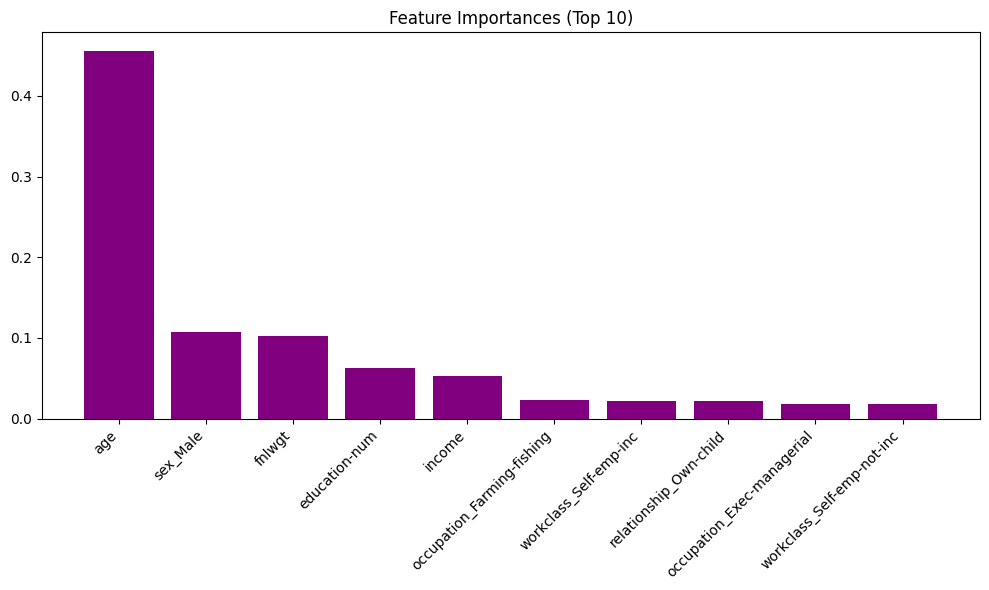

In [7]:
print("--- Final Evaluation on Test Set ---")

final_model = best_rf 

test_preds = final_model.predict(X_test_processed)

final_mae = mean_absolute_error(y_test, test_preds)
final_mse = mean_squared_error(y_test, test_preds)
final_rmse = np.sqrt(final_mse)
final_r2 = r2_score(y_test, test_preds)

print(f"Final Test MAE:  {final_mae:.4f}")
print(f"Final Test RMSE: {final_rmse:.4f}")
print(f"Final Test R2:   {final_r2:.4f}")

importances = final_model.feature_importances_
ohe_cols = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
all_feat_names = numeric_features + list(ohe_cols) + ['income', 'is-married']

indices = np.argsort(importances)[::-1][:10]
plt.figure(figsize=(10, 6))
plt.title("Feature Importances (Top 10)")
plt.bar(range(10), importances[indices], align="center", color='purple')
plt.xticks(range(10), [all_feat_names[i] for i in indices], rotation=45, ha='right')
plt.tight_layout()
plt.show()

**7. Concluzii:**

- Majoritatea oamenilor lucreaza fix 40 de ore, iar asta "pacaleste" modelele sa prezica mereu media.
- Chiar daca rezultatele sunt decente, cred ca pe viitor as putea sa incerc niste modele de tip ansamblu mai grele, sau poate chiar sa tratez problema ca pe una de clasificare pe intervale (part-time, full-time, overtime) pentru a obtine o acuratete mai utila in practica.